In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import seaborn as sns
import cvxopt as opt
from pandas_datareader import data
import yfinance as yf
import sympy
import time
import pyfolio as pf
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Moon\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 구분

In [2]:
#start와 end에 데이터 기간을 정해준다
start = datetime.datetime(2007, 6, 1)
end = datetime.datetime(2010, 1, 1)
#안전자산 : 장기 국채, 중기 국채, 단기 국채, 물가연동국채, 금, 원자재, 달러화, 엔화, 위험자산 후보군 : a_stock, k_stock
# 안전자산 8개, 위험자산 2개 총 10개
a_stock = data.DataReader('VTI', 'yahoo', start, end)
k_stock = data.DataReader('^KS11', 'yahoo', start, end)
l_bond = data.DataReader('TLT', 'yahoo', start, end)
m_bond = data.DataReader('IEI', 'yahoo', start, end)
s_bond = data.DataReader('SHY', 'yahoo', start, end)
tips = data.DataReader('TIP', 'yahoo', start, end)
gold = data.DataReader('GLD', 'yahoo', start, end)
comm = data.DataReader('GSG', 'yahoo', start, end)
dollar = data.DataReader('KRW=X', 'yahoo', start, end)
yen = data.DataReader('JPYKRW=X', 'yahoo', start, end)

In [3]:
a_stock_close = a_stock[['Adj Close']].rename(columns = {'Adj Close':'a_stock_close'})
k_stock_close = k_stock[['Adj Close']].rename(columns = {'Adj Close':'k_stock_close'})
I_bond_close = l_bond[['Adj Close']].rename(columns = {'Adj Close':'l_bond_close'})
m_bond_close = m_bond[['Adj Close']].rename(columns = {'Adj Close':'m_bond_close'})
s_bond_close = s_bond[['Adj Close']].rename(columns = {'Adj Close':'s_bond_close'})
tips_close = tips[['Adj Close']].rename(columns = {'Adj Close':'tips_close'})
gold_close = gold[['Adj Close']].rename(columns = {'Adj Close':'gold_close'})
comm_close = comm[['Adj Close']].rename(columns = {'Adj Close':'comm_close'})
dollar_close = dollar[['Adj Close']].rename(columns = {'Adj Close':'dollar_close'})
yen_close = yen[['Adj Close']].rename(columns = {'Adj Close':'yen_close'})

In [4]:
#Merge the tow tables above (표 병합)
price = pd.concat([a_stock_close,k_stock_close,I_bond_close,m_bond_close,s_bond_close,tips_close ,gold_close,comm_close,dollar_close,yen_close],axis=1)
price.dropna(axis=0)
#Calculate the daily return of individual stock (개별 주식 일별 수익률 계산)
#daily returns = (today price - previous day price)/(previous day price) - 1
pct_ret = np.log(1+price.pct_change()).dropna()
pct_ret = pct_ret.rename(columns={'a_stock_close':'a_stock','k_stock_close':'k_stock','l_bond_close':'I_bond','m_bond_close':'m_bond','s_bond_close':'s_bond','tips_close':'tips','gold_close':'gold','comm_close':'comm','dollar_close' : 'dollar','yen_close' : 'yen'})
log_ret = np.log(price).diff().dropna()
log_ret = log_ret.rename(columns={'a_stock_close':'a_stock','k_stock_close':'k_stock','l_bond_close':'I_bond','m_bond_close':'m_bond','s_bond_close':'s_bond','tips_close':'tips','gold_close':'gold','comm_close':'comm','dollar_close' : 'dollar','yen_close' : 'yen'})
log_ret

,a_stock,k_stock,I_bond,m_bond,s_bond,tips,gold,comm,dollar,yen
Date,,,,,,,,,,
2007-08-02,0.008450,-0.001822,0.002521,0.001893,0.000498,0.000500,-0.000607,-0.001359,0.001172,0.010376
2007-08-07,0.007500,0.002568,-0.000802,-0.001393,-0.000872,0.000100,-0.000601,0.009903,0.001517,-0.006061
2007-08-08,0.014970,0.023167,-0.012228,-0.001595,-0.000748,-0.003720,0.004353,-0.001644,-0.000065,0.011586
2007-08-09,-0.027525,0.002765,0.001392,0.004281,0.002864,0.003218,-0.019815,-0.005656,0.007745,0.006017
2007-08-14,-0.017584,-0.017109,0.002660,0.012043,0.001365,0.001201,0.000453,0.002113,-0.003141,0.010203
...,...,...,...,...,...,...,...,...,...,...
2009-12-22,0.005110,0.006855,-0.005612,-0.002789,-0.001199,-0.003257,-0.007320,0.000995,-0.007271,-0.015616
2009-12-23,0.003357,0.003503,0.000221,-0.000811,0.000000,-0.001441,0.003573,0.026188,0.003135,0.004974
2009-12-24,0.005103,0.012555,-0.010423,-0.001805,-0.001201,-0.002694,0.016845,0.005478,-0.022325,-0.020046


In [5]:
price = price.dropna()
price.columns = ['a_stock','k_stock','l_bond','m_bond','s_bond','tips','gold','comm','dollar','yen']

print(price.shape)

(503, 10)


In [6]:
price

,a_stock,k_stock,l_bond,m_bond,s_bond,tips,gold,comm,dollar,yen
Date,,,,,,,,,,
2007-08-01,54.203079,1856.449951,56.272236,77.709175,66.603218,64.420395,65.930000,44.180000,920.780029,7.7277
2007-08-02,54.663040,1853.069946,56.414299,77.856400,66.636406,64.452614,65.889999,44.119999,921.859985,7.8083
2007-08-06,54.139500,1855.050049,56.375568,77.926147,66.719421,64.227020,66.519997,42.200001,922.130005,7.7615
2007-08-07,54.547092,1859.819946,56.330360,77.817673,66.661293,64.233459,66.480003,42.619999,923.530029,7.7146
2007-08-08,55.369804,1903.410034,55.645752,77.693672,66.611473,63.994961,66.769997,42.549999,923.469971,7.8045
...,...,...,...,...,...,...,...,...,...,...
2009-12-23,44.767223,1661.349976,64.546394,92.719307,74.618187,75.821175,106.550003,30.950001,1182.199951,12.8990
2009-12-24,44.996239,1682.339966,63.877132,92.552116,74.528641,75.617157,108.360001,31.120001,1156.099976,12.6430
2009-12-28,45.051502,1685.589966,63.699100,92.267860,74.421211,75.595306,108.550003,31.490000,1170.199951,12.7600


# 시작일로부터 증감률

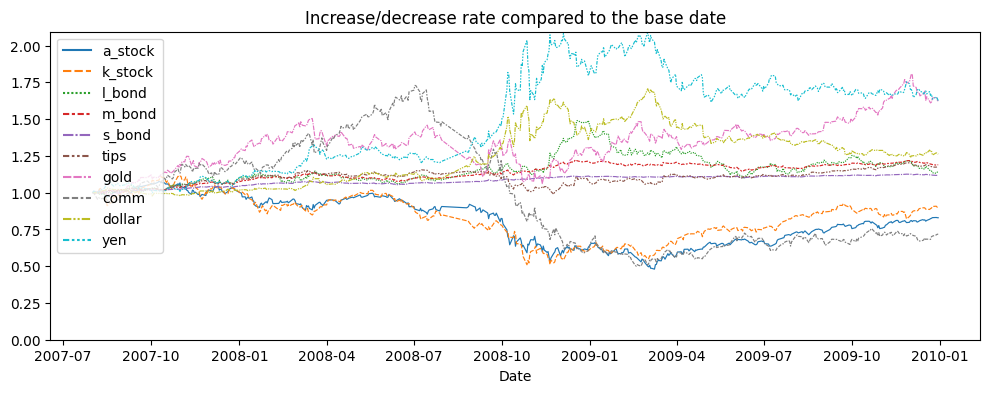

In [7]:
price_rate = price/price.iloc[0] # 기준일(2022-02-23) 대비 증감

plt.figure(figsize=(12,4))
sns.lineplot(data=price_rate, linewidth=0.85)
plt.ylim((0, price_rate.max().max()))
plt.title('Increase/decrease rate compared to the base date')
plt.show()

<AxesSubplot: title={'center': "Correlation of all asset's percent change"}>

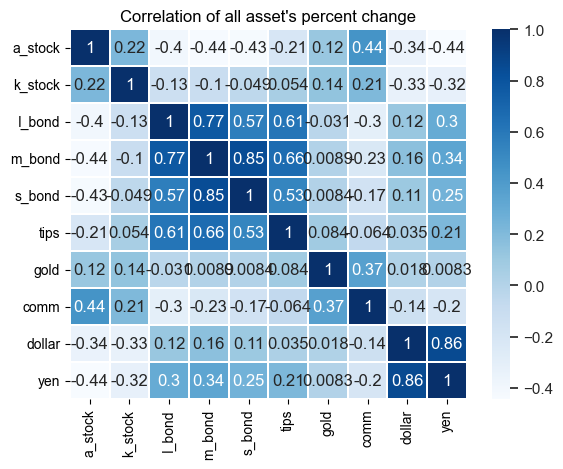

In [8]:
# 일일 수익률 간 상관관계 시각화

plt.title("Correlation of all asset's percent change")
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(log_ret.corr(), cmap='Blues', linewidth=0.2, annot=True)

# 안전자산 비중 설정

In [11]:
#Generate random weights (무작위 가중치 생성)

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

# 포트폴리오 최적화

In [14]:
port_ratios = []

# 주식의 일별 및 총 기간 수익을 계산
returns_annual = log_ret.mean() * 252

# 주식 수익의 일별 및 공분산을 계산
cov_daily = log_ret.cov()
cov_annual = cov_daily * 252

# 포트폴리오의 수익률, 변동성 및 가중치를 저장하기 위한 빈 리스트
port_returns = np.array([])
port_volatility = np.array([])
sharpe_ratio = np.array([])
stock_weights = []

# N개의 무작위 포트폴리오 생성 (300000개)
num_assets = len(price.columns)
num_portfolios = 300000

# 빈 리스트를 각 포트폴리오의 수익률, 변동성 및 가중치로 채워줍니다.
for single_portfolio in range(num_portfolios):
    weights = rand_weights(len(price.columns))
    port_ratios.append(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio = np.append(sharpe_ratio, sharpe)
    port_returns = np.append(port_returns, returns)
    port_volatility = np.append(port_volatility, volatility)
    stock_weights.append(weights)

# 각 포트폴리오의 수익률 및 리스크를 사전정리
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(price.columns):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# 포트폴리오를 DataFrame 형태로 만들어준다.
df = pd.DataFrame(portfolio)

column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in price.columns]

# DataFrame columns 재정의
df = df[column_order]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26676\1797604996.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


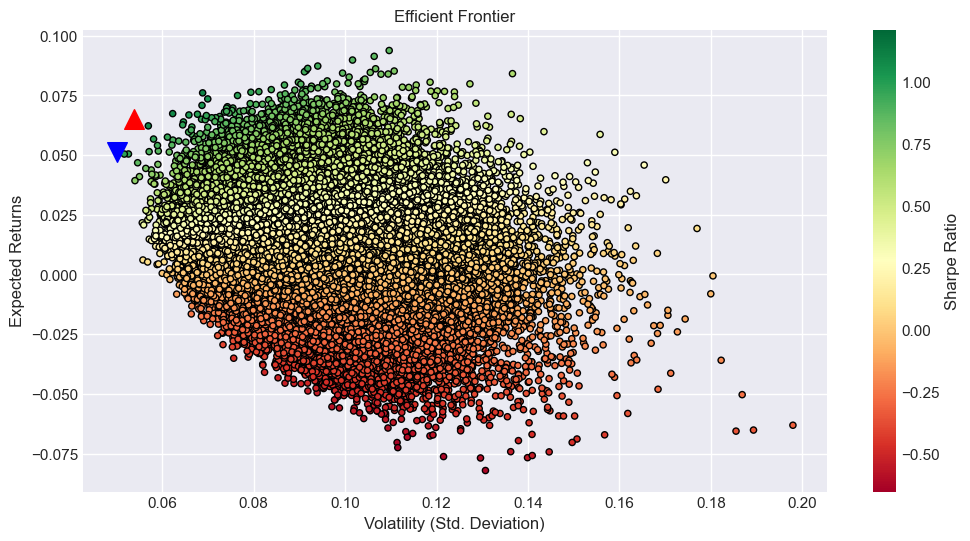

In [15]:
# DataFrame에서 최소 변동성 및 최대 샤프지수 값 찾기(df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# 최소 변동성 값, 최대 샤프지수 값을 사용하여 두 개의 특수 포트폴리오를 찾고 생성합니다.
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# Efficient Frontier(Minimum-variance), max sharpe & min Volatility values를 scatterplot을 이용하여 시각화
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(12, 6), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='^', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='v', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# 샤프지수에 따른 포트폴리오 비율 시각화

In [16]:
sorted_shape_idx2 = np.argsort(sharpe_ratio)
sorted_risk_idx2 = np.argsort(port_volatility)

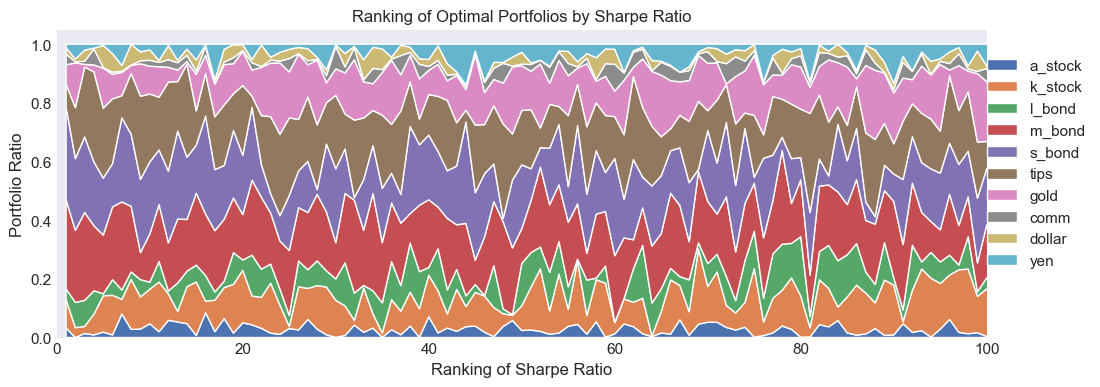

In [17]:
#샤프지수가 높은 상위 100개 포트폴리오 비율
port_df = pd.DataFrame(port_ratios)
sorted_port_df2 = port_df.iloc[sorted_shape_idx2[::-1]] # 역순
sorted_port_df2.columns = price.columns

plt.figure(figsize=(12,4))
plt.stackplot(np.arange(1,len(sorted_port_df2)+1,1), np.array(sorted_port_df2.T), labels=sorted_port_df2.columns)

plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.12,0.95))
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Portfolio Ratio')
plt.title('Ranking of Optimal Portfolios by Sharpe Ratio')
plt.show()

# 샤프 지수에 따른 포트폴리오 수익률 및 변동성

In [18]:
# print the details of the 2 special portfolios
print(f'최소 위험도 포트폴리오 비율 : \n {min_variance_port.T}')
print(f'최적의 포트폴리오 비율 : \n {sharpe_portfolio.T}')

최소 위험도 포트폴리오 비율 : 
                    76197
Returns         0.051364
Volatility      0.049992
Sharpe Ratio    1.027452
a_stock Weight  0.080264
k_stock Weight  0.049997
l_bond Weight   0.031614
m_bond Weight   0.300220
s_bond Weight   0.286985
tips Weight     0.075070
gold Weight     0.079666
comm Weight     0.004002
dollar Weight   0.019613
yen Weight      0.072569
최적의 포트폴리오 비율 : 
                    79650
Returns         0.065030
Volatility      0.053755
Sharpe Ratio    1.209749
a_stock Weight  0.032326
k_stock Weight  0.097196
l_bond Weight   0.036398
m_bond Weight   0.303804
s_bond Weight   0.315853
tips Weight     0.077945
gold Weight     0.066054
comm Weight     0.036561
dollar Weight   0.021789
yen Weight      0.012074
